In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from net import NormalNetwork, PCANetwork, train_network, test_network

#### Train with MNIST dataset

In [2]:
model = NormalNetwork()

In [3]:
train_network(model)

Training epoch 0:  79%|█████████████████████████████████████████████▊            | 1483/1875 [00:07<00:02, 185.46it/s]


KeyboardInterrupt: 

#### Test with MNIST dataset

In [4]:
res = test_network(model)
print(res)

100%|██████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 183.49it/s]

{'accuracy': 0.9806, 'loss': 0.06424408016796158, 'confusion matrix': array([[ 972,    0,    1,    0,    1,    2,    0,    1,    2,    1],
       [   0, 1126,    4,    0,    0,    2,    2,    0,    1,    0],
       [   3,    2, 1017,    2,    1,    0,    1,    2,    4,    0],
       [   0,    0,    5,  990,    0,    4,    0,    2,    1,    8],
       [   0,    0,    4,    1,  965,    0,    2,    2,    0,    8],
       [   2,    0,    0,    6,    2,  878,    2,    1,    0,    1],
       [   5,    3,    1,    1,    5,    8,  932,    1,    2,    0],
       [   2,    6,    8,    1,    3,    0,    0,  995,    2,   11],
       [   3,    0,    5,    6,    4,    4,    2,    2,  943,    5],
       [   3,    2,    1,    4,    7,    3,    0,    0,    1,  988]])}


#### Plot confusion matrix

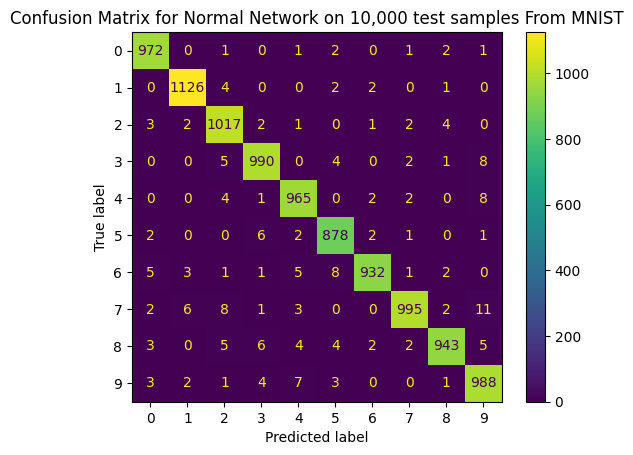

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix= res["confusion matrix"])
disp.plot()
plt.title("Confusion Matrix for Normal Network on 10,000 test samples From MNIST")
plt.show()

#### Train with PCA data

In [2]:
model = PCANetwork()

In [3]:
train_network(model)

Training epoch 19: 100%|████████████████████████████████████████████████████████| 1875/1875 [00:01<00:00, 1678.42it/s]


In [4]:
test_network(model)

100%|███████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 81.87it/s]


{'accuracy': 0.9757,
 'loss': 0.08613974724465924,
 'confusion matrix': array([[ 970,    0,    0,    0,    0,    4,    2,    1,    3,    0],
        [   0, 1126,    3,    0,    0,    1,    1,    1,    3,    0],
        [   4,    4, 1003,    3,    1,    0,    3,    7,    6,    1],
        [   0,    1,    0,  990,    0,    7,    0,    4,    2,    6],
        [   2,    0,    5,    0,  960,    0,    5,    3,    1,    6],
        [   2,    2,    0,    8,    1,  871,    1,    2,    3,    2],
        [   3,    3,    4,    1,    5,    9,  931,    1,    1,    0],
        [   0,    6,    9,    1,    2,    1,    0,  995,    4,   10],
        [   4,    0,    4,   10,    2,    5,    3,    4,  937,    5],
        [   3,    3,    0,    8,   10,    4,    0,    6,    1,  974]])}

In [1]:
from graph import draw_metric_graph

In [3]:
draw_metric_graph(epochs=5)

Initializing networks...


KeyboardInterrupt: 